In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

%load_ext autoreload
%autoreload 2
from delay_discounting_mvpa.config_loader import load_config
from delay_discounting_mvpa.design_utils import create_design_matrices
from delay_discounting_mvpa.io_utils import get_subids, load_tsv_data, resolve_file


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## What is in here?
At various points throughout the analysis I needed to orient myself with what the data looked like.  Those data inspections are collected here.

In [2]:
config_file = '/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/delay_discounting_mvpa/configs/config.yaml'
cfg = load_config(config_file)

In [3]:
subids = get_subids(cfg)

## Basic behavioral data distributions
I wondered whether the `large_amount` range varied by subject as well as the `later_delay` distribution.  May as well look at `response_time` while I'm here.

In [4]:
events_all = []

for subid in subids:
    try:
        behav_file = resolve_file(cfg, subid, 'behav')
        df = load_tsv_data(behav_file)
        df['sub_id'] = subid  # track subject
        events_all.append(df)
    except:
        continue

events_combined = pd.concat(events_all, ignore_index=True)

In [5]:
events_combined['small_amount'].unique()  # should all be 20

array([20.])

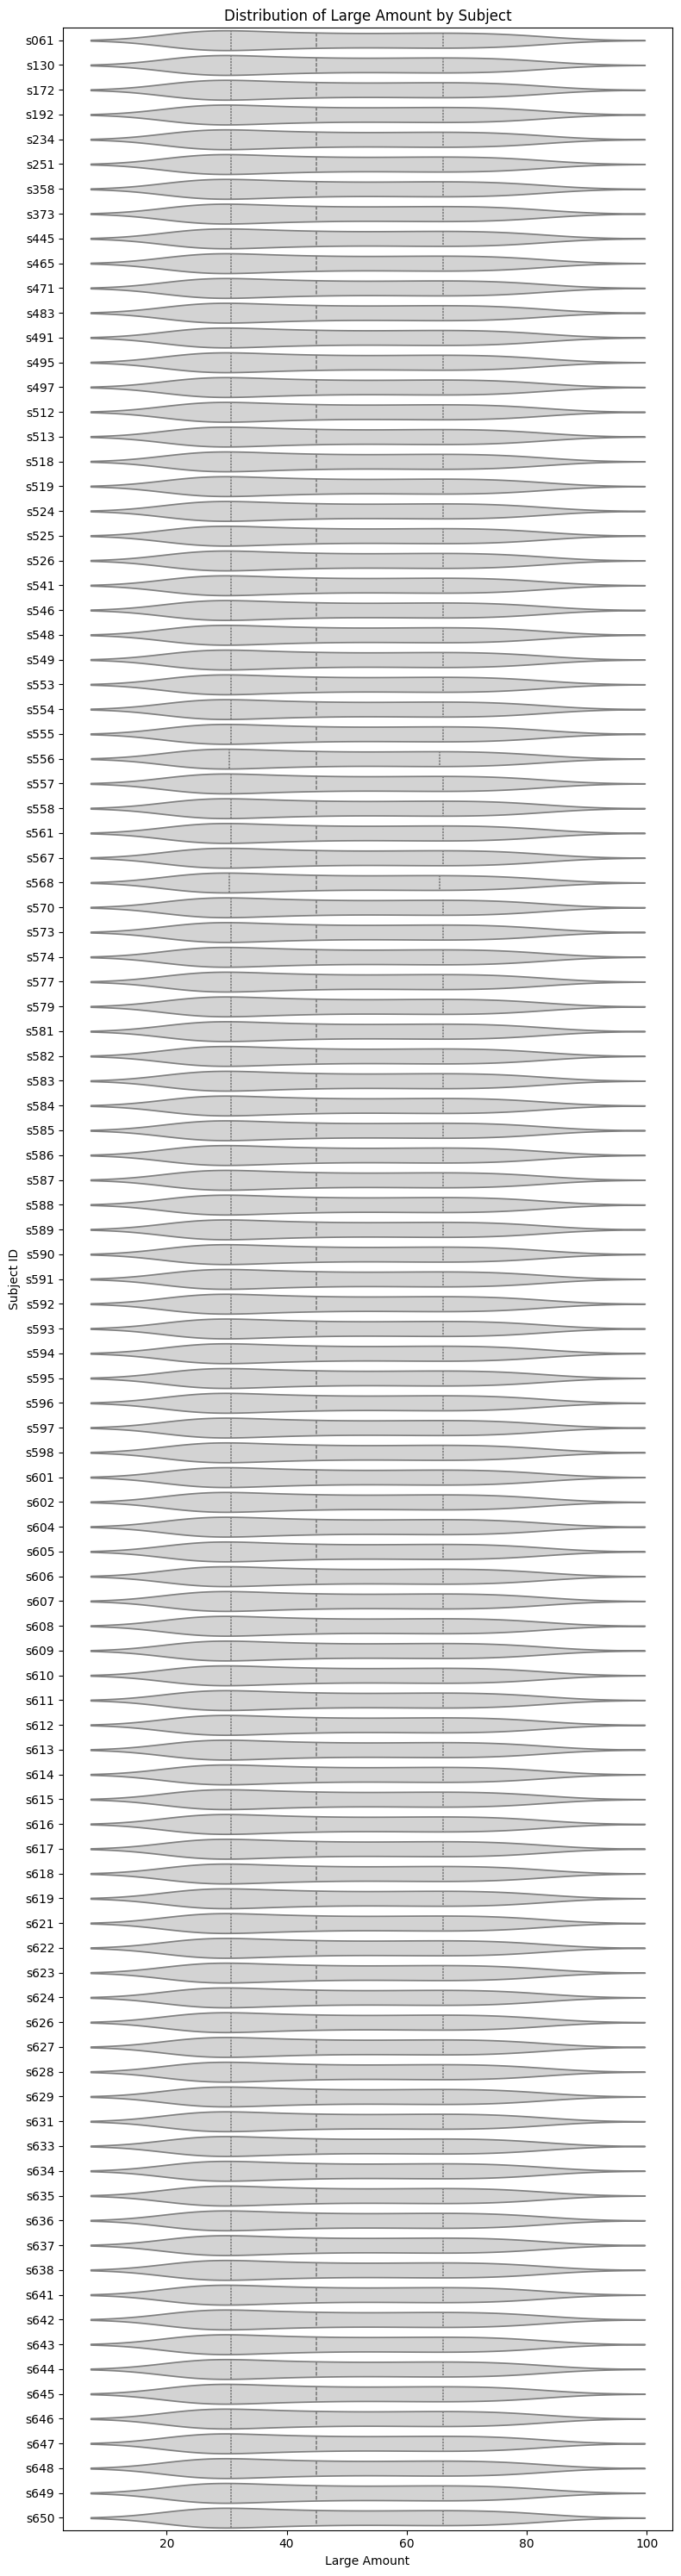

In [6]:
events_combined['sub_id'] = events_combined['sub_id'].astype(str)

plt.figure(figsize=(8, 30))
sns.violinplot(
    x='large_amount',
    y='sub_id',
    data=events_combined,
    density_norm='width',  # scale violins to same width for easier comparison
    inner='quartile',  # optional: show quartiles inside each violin
    color='lightgray',  # simple uniform color
)

plt.xlabel('Large Amount')
plt.ylabel('Subject ID')
plt.title('Distribution of Large Amount by Subject')
plt.tight_layout()
plt.show()


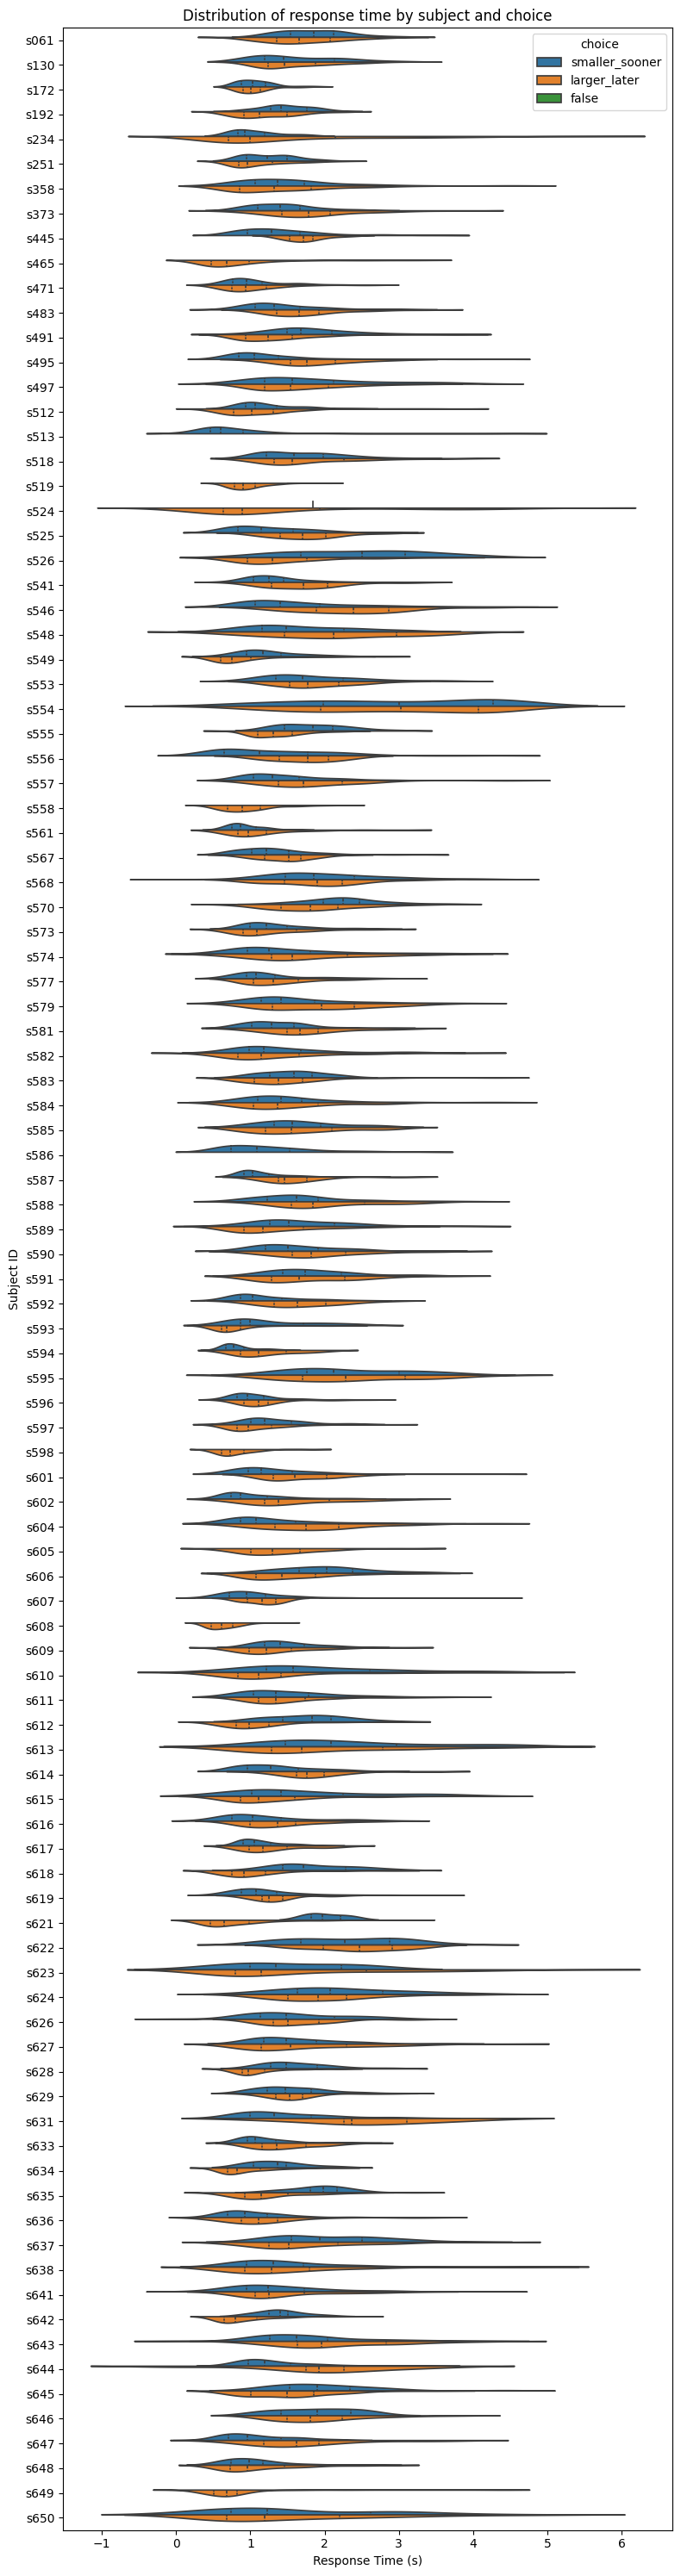

In [7]:
# response time
plt.figure(figsize=(8, 30))
sns.violinplot(
    x='response_time',
    y='sub_id',
    data=events_combined,
    density_norm='width',
    inner='quartile',
    hue='choice',
    split=True,
)

plt.xlabel('Response Time (s)')
plt.ylabel('Subject ID')
plt.title('Distribution of response time by subject and choice')
plt.tight_layout()
plt.show()


### No longer relevant, but I previously was looking at the balance of choices across subjects
This was more relevant when I thought were were trying to run a classifier predicting choice.  I figured I would keep this code just in case

In [11]:
# Step 1: Build counts per subject
records = []

for subid in subids:
    try:
        behav_file = resolve_file(cfg, subid, 'behav')
        events_data_loop = load_tsv_data(behav_file)
    except (FileNotFoundError, KeyError, ValueError) as e:
        print(f'Skipping {subid} due to error: {e}')
        continue

    # Count the 'choice' values
    choice_counts = Counter(events_data_loop['choice'])

    records.append(
        {
            'subid': subid,
            'smaller_sooner': choice_counts.get('smaller_sooner', 0),
            'larger_later': choice_counts.get('larger_later', 0),
            'false': choice_counts.get('false', 0),
        }
    )

# Create dataframe
choice_counts_df = pd.DataFrame(records)
print(choice_counts_df)

Skipping s144 due to error: No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s144_discountFix_events.tsv
Skipping s499 due to error: No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s499_discountFix_events.tsv
Skipping s533 due to error: No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s533_discountFix_events.tsv
Skipping s572 due to error: No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s572_discountFix_events.tsv
Skipping s603 due to error: No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s603_discountFix_events.tsv
Skipping s639 due to error: No files found for 'behav' with pattern: /oak/stanford/groups/russpold/data/uh2/aim1/behavioral_data/event_files/s639_discountF

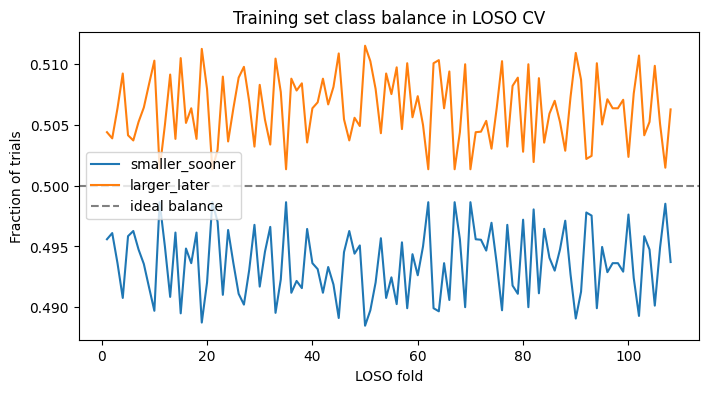

In [13]:
# Step 2: Assess LOSO training set balance
n_subs = len(subids)
fold_fractions = []

for test_idx, test_sub in enumerate(subids):
    # Exclude test subject
    train_df = choice_counts_df[choice_counts_df['subid'] != test_sub]

    # Sum counts across training subjects, ignoring 'false'
    train_smaller = train_df['smaller_sooner'].sum()
    train_larger = train_df['larger_later'].sum()

    total_valid = train_smaller + train_larger
    fraction_larger = train_larger / total_valid
    fraction_smaller = train_smaller / total_valid

    fold_fractions.append(
        {
            'fold': test_idx + 1,
            'test_sub': test_sub,
            'fraction_smaller': fraction_smaller,
            'fraction_larger': fraction_larger,
            'total_valid_trials': total_valid,
        }
    )

fold_balance_df = pd.DataFrame(fold_fractions)

# Step 3: Visualize
plt.figure(figsize=(8, 4))
plt.plot(
    fold_balance_df['fold'], fold_balance_df['fraction_smaller'], label='smaller_sooner'
)
plt.plot(
    fold_balance_df['fold'], fold_balance_df['fraction_larger'], label='larger_later'
)
plt.axhline(0.5, color='gray', linestyle='--', label='ideal balance')
plt.xlabel('LOSO fold')
plt.ylabel('Fraction of trials')
plt.title('Training set class balance in LOSO CV')
plt.legend()
plt.show()